Implementation of *eSRGAN* based on https://arxiv.org/pdf/1809.00219.pdf

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math
import argparse
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from torch.autograd import Variable
import numpy as np

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--epoch", type=int, default=0, help="Epoch to start training from")
parser.add_argument("--n_epoch", type=int, default=1, help="total number of epochs for training")
parser.add_argument("--batch_size", type=int, default=3, help="Size of batches")
parser.add_argument("--lr", type=float, default=0.0002, help="Learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="Decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="Decay of second order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=100, help="Epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=8, help="Number of cpu threads to use during batch generation")
parser.add_argument("--hr_height", type=int, default=512, help="High res. image height")
parser.add_argument("--hr_width", type=int, default=512, help="High res. image width")
parser.add_argument("--channels", type=int, default=3, help="Number of image channels")
parser.add_argument("--sample_interval", type=int, default=1000, help="Interval between saving image samples")
parser.add_argument("--checkpoint_interval", type=int, default=5000, help="Batch interval between model checkpoints")
parser.add_argument("--residual_blocks", type=int, default=15, help="Number of residual blocks in the generator")
parser.add_argument("--warmup_batches", type=int, default=500, help="Number of batches with pixel-wise loss only")
parser.add_argument("--lambda_adv", type=float, default=5e-3, help="Adversarial loss weight")
parser.add_argument("--lambda_pixel", type=float, default=1e-2, help="Pixel-wise loss weight")
opt = parser.parse_args(args=[])
opt

Namespace(b1=0.9, b2=0.999, batch_size=3, channels=3, checkpoint_interval=5000, decay_epoch=100, epoch=0, hr_height=512, hr_width=512, lambda_adv=0.005, lambda_pixel=0.01, lr=0.0002, n_cpu=8, n_epoch=1, residual_blocks=15, sample_interval=1000, warmup_batches=500)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
hr_shape = (opt.hr_height, opt.hr_width)

In [5]:
## VGG 19 feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)

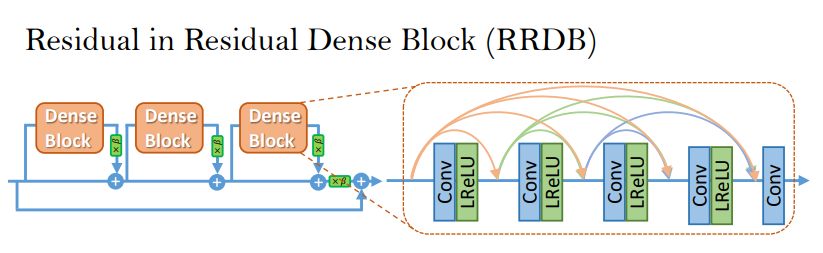

In [6]:
class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.Conv2d(in_features, filters, 3, 1, 1, bias=True)]
            if non_linearity:
                layers += [nn.LeakyReLU()]
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x

In [7]:
class ResInResDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResInResDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)
        )
        
    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x


In [8]:
class GeneratorRRDB(nn.Module):
    def __init__(self, channels, filters=64, num_res_blocks=16, num_upsample=2):
        super(GeneratorRRDB, self).__init__()

        # First layer
        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResInResDenseBlock(filters) for _ in range(num_res_blocks)])
        # Second conv layer post residual blocks
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        # Upsampling layers
        upsample_layers = []
        for _ in range(num_upsample):
            upsample_layers += [
                nn.Conv2d(filters, filters * 4, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(),
                nn.PixelShuffle(upscale_factor=2),
            ]
        self.upsampling = nn.Sequential(*upsample_layers)
        # Final output block
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(filters, channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [10]:
# Initialize generator and discriminator
generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(device)
discriminator = Discriminator(input_shape=(opt.channels, *hr_shape)).to(device)
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

FeatureExtractor(
  (vgg19_54): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride

In [11]:
# Losses
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)
criterion_content = torch.nn.L1Loss().to(device)
criterion_pixel = torch.nn.L1Loss().to(device)

In [12]:
if opt.epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth" % opt.epoch))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth" % opt.epoch))

In [13]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [14]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

In [15]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [17]:
def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return torch.clamp(tensors, 0, 255)

In [18]:
class MyDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        super(MyDataset, self).__init__()
        self.lr_filenames = os.listdir(lr_dir)
        self.hr_filenames = os.listdir(hr_dir)
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        
    def __getitem__(self, index):
        lr_filename = self.lr_filenames[index]
        hr_filename = self.hr_filenames[index]
        lr_img = Image.open(os.path.join(self.lr_dir, lr_filename)).convert('RGB')
        hr_img = Image.open(os.path.join(self.hr_dir, hr_filename)).convert('RGB')
        
        if self.transform is not None:
            lr_img = self.transform(lr_img)
            hr_img = self.transform(hr_img)
        
        return lr_img.to(device), hr_img.to(device)
    
    def __len__(self):
        return len(self.lr_filenames)

In [19]:
dataset = MyDataset(lr_dir='/kaggle/input/image-restoration-minor-128x128',
                        hr_dir='/kaggle/input/image-restoration-minor-512x512',
                        transform=transform)

In [20]:
dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True, pin_memory=False)

In [21]:
if not os.path.exists('images/training/'):
    print("Created Image logs folder")
    os.makedirs('images/training/')
    
if not os.path.exists('saved_models/'):
    print("Created Saved models folder")
    os.makedirs('saved_models/')

Created Image logs folder
Created Saved models folder


In [22]:
img_lr_test = transform(Image.open(os.path.join('/kaggle/input/image-restoration-minor-128x128', 'patch_000000878.jpg'))
                        .convert('RGB')).to(device)
img_hr_test = transform(Image.open(os.path.join('/kaggle/input/image-restoration-minor-512x512', 'patch_000000878.jpg'))
                        .convert('RGB'))
img_grid = denormalize(img_lr_test)
save_image(img_grid, "images/training/og_lr.png", nrow=1, normalize=False)
img_grid = denormalize(img_hr_test)
save_image(img_grid, "images/training/og_hr.png", nrow=1, normalize=False)

In [23]:
with torch.no_grad():
    generator.eval()
    gen_hr = generator(img_lr_test.unsqueeze(0))
    img_grid = denormalize(gen_hr)
    save_image(img_grid, "images/training/test.png", nrow=1, normalize=False)
    generator.train()

In [24]:
for epoch in range(opt.epoch, opt.n_epoch):
    for i, imgs in enumerate(dataloader):
        batches_done = epoch * len(dataloader) + i

        # Configure model input
        imgs_lr = Variable(imgs[0])
        imgs_hr = Variable(imgs[1])

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------
        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Measure pixel-wise loss against ground truth
        loss_pixel = criterion_pixel(gen_hr, imgs_hr)

        if batches_done < opt.warmup_batches:
            # Warm-up (pixel-wise loss only)
            imgs_lr
            loss_pixel.backward()
            optimizer_G.step()
            if batches_done % 50 == 0:
                print(
                    "[Epoch %d/%d] [Batch %d/%d] [G pixel: %f]"
                    % (epoch, opt.n_epoch, i, len(dataloader), loss_pixel.item())
                )
            if batches_done % opt.sample_interval == 0:
                # Save Test image passes to generator
                with torch.no_grad():
                    generator.eval()
                    gen_hr = generator(img_lr_test.unsqueeze(0))
                    img_grid = denormalize(gen_hr)
                    save_image(img_grid, "images/training/%d.png" % batches_done, nrow=1, normalize=False)
                    generator.train()
            continue
        # Extract validity predictions from discriminator
        pred_real = discriminator(imgs_hr).detach()
        pred_fake = discriminator(gen_hr)

        # Adversarial loss (relativistic average GAN)
        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr).detach()
        loss_content = criterion_content(gen_features, real_features)

        # Total generator loss
        loss_G = loss_content + opt.lambda_adv * loss_GAN + opt.lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        pred_real = discriminator(imgs_hr)
        pred_fake = discriminator(gen_hr.detach())

        # Adversarial loss for real and fake images (relativistic average GAN)
        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------
        if batches_done % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, content: %f, adv: %f, pixel: %f]"
                % (
                    epoch,
                    opt.n_epoch,
                    i,
                    len(dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_content.item(),
                    loss_GAN.item(),
                    loss_pixel.item(),
                )
            )

        if batches_done % opt.sample_interval == 0:
            # Save image grid with upsampled inputs and ESRGAN outputs
            with torch.no_grad():
                generator.eval()
                gen_hr = generator(img_lr_test.unsqueeze(0))
                img_grid = denormalize(gen_hr)
                save_image(img_grid, "images/training/%d.png" % batches_done, nrow=1, normalize=False)
                generator.train()

        if batches_done % opt.checkpoint_interval == 0:
            # Save model checkpoints
            torch.save(generator.state_dict(), f"saved_models/generator_{epoch}_{batches_done}.pth")
            torch.save(discriminator.state_dict(), f"saved_models/discriminator_{epoch}_{batches_done}.pth")

[Epoch 0/1] [Batch 0/14354] [G pixel: 0.836861]
[Epoch 0/1] [Batch 50/14354] [G pixel: 0.218454]
[Epoch 0/1] [Batch 100/14354] [G pixel: 0.130648]
[Epoch 0/1] [Batch 150/14354] [G pixel: 0.191081]
[Epoch 0/1] [Batch 200/14354] [G pixel: 0.266332]
[Epoch 0/1] [Batch 250/14354] [G pixel: 0.200854]
[Epoch 0/1] [Batch 300/14354] [G pixel: 0.163897]
[Epoch 0/1] [Batch 350/14354] [G pixel: 0.066885]
[Epoch 0/1] [Batch 400/14354] [G pixel: 0.162459]
[Epoch 0/1] [Batch 450/14354] [G pixel: 0.095416]
[Epoch 0/1] [Batch 500/14354] [D loss: 0.738132] [G loss: 0.625109, content: 0.621074, adv: 0.685559, pixel: 0.060696]
[Epoch 0/1] [Batch 550/14354] [D loss: 0.092785] [G loss: 1.142344, content: 1.120930, adv: 2.726896, pixel: 0.778019]
[Epoch 0/1] [Batch 600/14354] [D loss: 0.009684] [G loss: 1.634915, content: 1.601000, adv: 5.227770, pixel: 0.777650]
[Epoch 0/1] [Batch 650/14354] [D loss: 0.002374] [G loss: 1.196217, content: 1.150489, adv: 6.839204, pixel: 1.153168]
[Epoch 0/1] [Batch 700/1435